<a href="https://colab.research.google.com/github/Mizoroki-Heck/Nornikel_Hack/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект по сегментации дефектов на изображениях
### Задача:
Цель проекта — разработка системы для автоматической сегментации дефектов на изображениях с использованием методов глубокого обучения.

### 1. Установка библиотек

Первым шагом устанавливаем необходимые библиотеки:

In [3]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lsqmlb18
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-lsqmlb18
  Resolved https://github.com/tensorflow/examples.git to commit 652ee34ff046946c36b8aed5d97ecebab0699f7e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1734446297.577653703822934887080861169866359378810363289470-py3-none-any.whl size=301604 sha256=6c1c4d47d69d80bac06e1cb1a584211dc0c10f9d0e313a131ed91eccf0f6f9fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-xw1iznr9/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


## 2. Импорт модулей и подключение Google Drive

Подключаем стандартные библиотеки для работы с TensorFlow, обработки изображений и визуализации. Также монтируем Google Drive для доступа к данным.

In [4]:
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
import keras
import cv2
from tensorflow.keras import layers, models
from tensorflow_examples.models.pix2pix import pix2pix

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Распаковка данных

Распаковываем архив с тренировочными данными:

In [6]:
!unzip "/content/drive/MyDrive/datasets/train_dataset.zip" -d "/content/"

Archive:  /content/drive/MyDrive/datasets/train_dataset.zip
   creating: /content/cv_open_dataset/
   creating: /content/cv_open_dataset/open_img/
  inflating: /content/cv_open_dataset/open_img/1710275253_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710277054_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710322071_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710370672_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710381477_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710390473_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710399478_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710430072_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710458871_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710584874_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710604665_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710809853_0.jpg  
  inflating: /content/cv_open_dataset/open_img/1710811652_0.j

## 4. Подготовка данных
### 4.1. Создание списков путей к изображениям и маскам

Сортируем и объединяем пути для загрузки:

In [7]:
image_paths = sorted(glob.glob("/content/cv_open_dataset/open_img/*.jpg") +
                     glob.glob("/content/cv_synt_dataset/synt_img/*.png"))
mask_paths = sorted(glob.glob("/content/cv_open_dataset/open_msk/*.png") +
                    glob.glob("/content/cv_synt_dataset/synt_msk/*.png"))

### 4.2. Создание TensorFlow Dataset

Создаем tf.data.Dataset для изображений и масок, разделяем данные на обучающую и тестовую выборки.

In [8]:
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
mask_dataset = tf.data.Dataset.from_tensor_slices(mask_paths)

In [9]:
n_train = int(len(image_dataset)*0.7)
n_test = int(len(image_dataset)*0.3)
print(n_train, n_test)

221 95


In [10]:
dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))
train_dataset = dataset.take(n_train)
test_dataset = dataset.skip(n_train)

## 5. Препроцессинг данных
### 5.1. Нормализация

Приводим значения пикселей изображений и масок к диапазону [0, 1]:

In [11]:
def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255
    mask = mask / 113
    return image, mask

### 5.2. Функция загрузки и обработки данных

Загружаем изображения и маски, изменяем их размер и применяем нормализацию:

In [12]:
def load_image(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image, channels=3)

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_image(mask, channels=1)

    image.set_shape([None, None, 3])
    mask.set_shape([None, None, 1])

    image = tf.image.resize(image, (224, 224))
    mask = tf.image.resize(mask, (224, 224), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    image, mask = normalize(image, mask)
    return image, mask

In [13]:
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

## 6. Аугментация данных

Добавляем горизонтальные перевороты для увеличения разнообразия данных.

In [14]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

## 7. Подготовка батчей

Создаем батчи для обучения и тестирования, добавляем кэширование и предвыборку:

In [15]:
train_batches = (
    train_dataset
    .cache()
    .batch(8)
    .repeat(5)
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_batches = test_dataset.batch(8)

## 8. Визуализация данных

Функция для отображения исходного изображения, маски и предсказания модели:

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

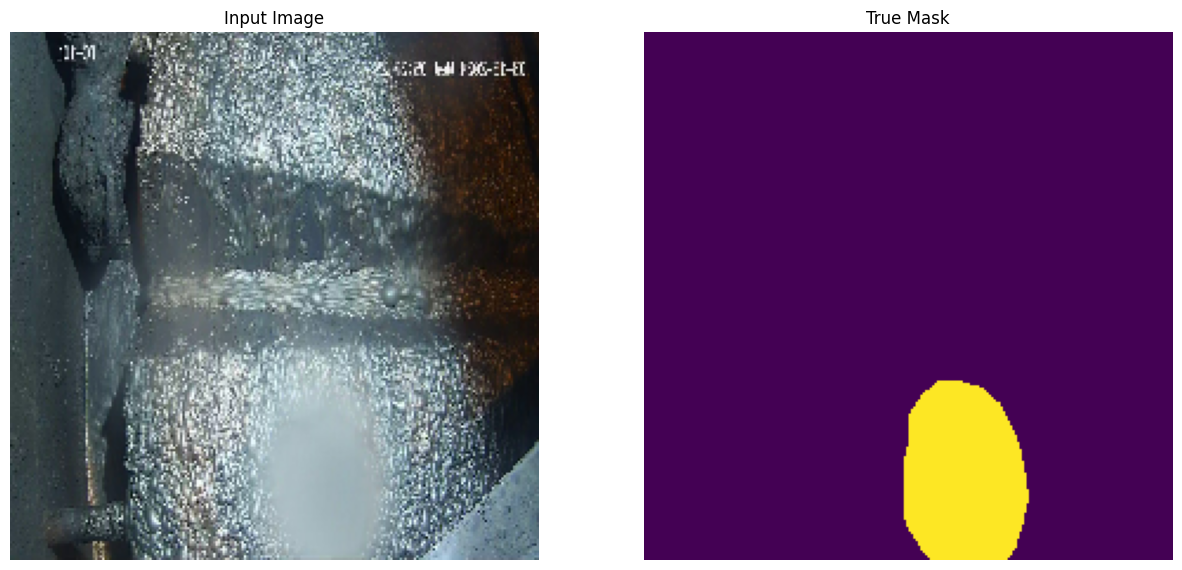

In [17]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## 9. Создание модели UNet
### 9.1. Использование MobileNetV2

Берем предобученную модель MobileNetV2 для извлечения признаков.

In [18]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### 9.2. Слои декодирования

Добавляем слои апсемплинга для восстановления разрешения изображения.

In [19]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])


  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same', activation='sigmoid')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [21]:
model = unet_model(output_channels=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['Accuracy', tf.keras.metrics.BinaryIoU()])

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=2):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask[0]])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## 10. Обучение модели

Запускаем процесс обучения модели на 25 эпохах:

In [24]:
EPOCHS = 25
model.fit(train_batches, validation_data=train_batches, epochs=EPOCHS)

Epoch 1/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 47s 206ms/step - Accuracy: 0.5609 - binary_io_u: 0.3212 - loss: 0.6808 - val_Accuracy: 0.6087 - val_binary_io_u: 0.2911 - val_loss: 0.6441
Epoch 2/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - Accuracy: 0.6283 - binary_io_u: 0.3574 - loss: 0.6159 - val_Accuracy: 0.6583 - val_binary_io_u: 0.3250 - val_loss: 0.5745
Epoch 3/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 81ms/step - Accuracy: 0.6693 - binary_io_u: 0.3981 - loss: 0.5596 - val_Accuracy: 0.7090 - val_binary_io_u: 0.3865 - val_loss: 0.4893
Epoch 4/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - Accuracy: 0.7121 - binary_io_u: 0.4456 - loss: 0.5108 - val_Accuracy: 0.7512 - val_binary_io_u: 0.4497 - val_loss: 0.4227
Epoch 5/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - Accuracy: 0.7527 - binary_io_u: 0.4908 - loss: 0.4742 - val_Accuracy: 0.7870 - val_binary_io_u: 0.5101 - val_loss: 0.3736
Epoch 6/25
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - Accuracy: 0.7858 - binary_io_u: 0.5325 - loss: 0.4448

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


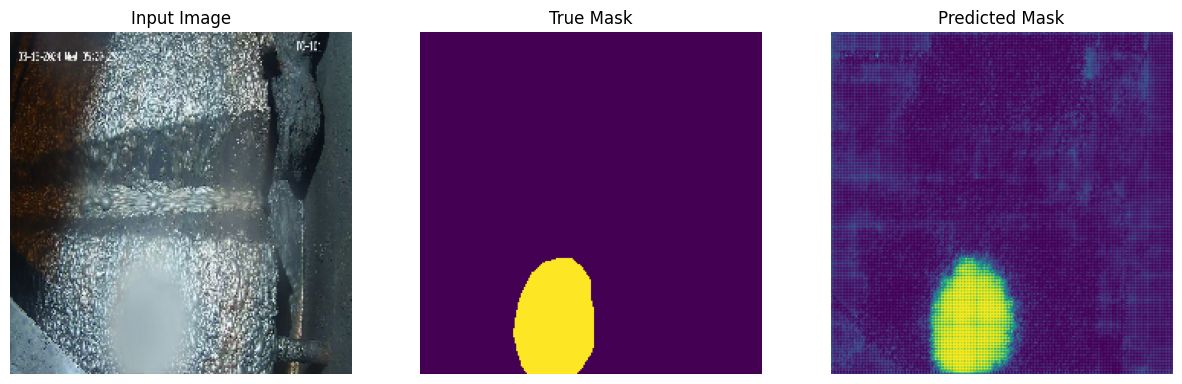

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


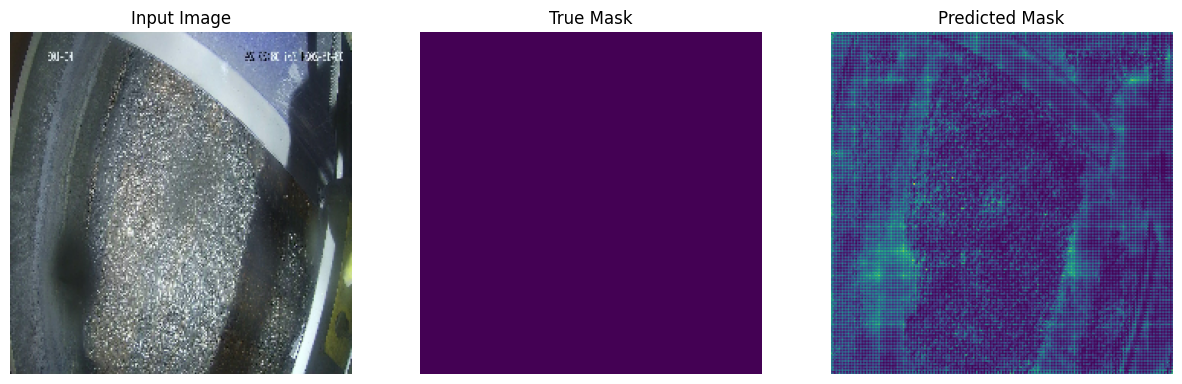

In [25]:
show_predictions(train_batches)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


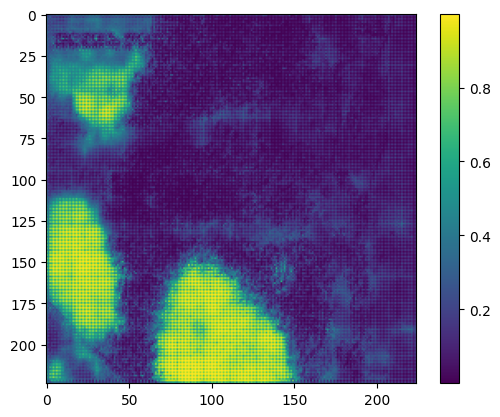

In [28]:
image = cv2.imread(image_paths[25])
image = tf.image.resize(image, (224, 224))

image = tf.reshape(image, (1,) + (224, 224) + (3,))
image = image / 255.0
pred = model.predict(image)
pred = pred.reshape((224, 224) + (1,))

plt.imshow(pred)
plt.colorbar()

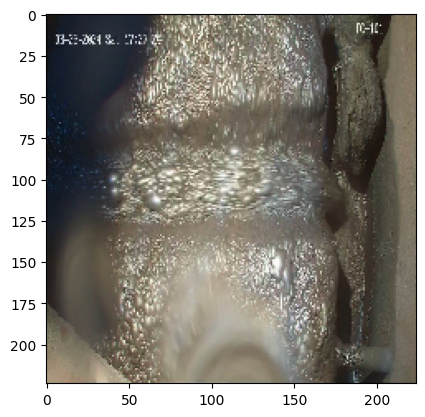

In [29]:
image = cv2.imread(image_paths[25])
image = tf.image.resize(image, (224, 224))

image = tf.reshape(image, (224, 224, 3))
image /= 255.
plt.imshow(image)

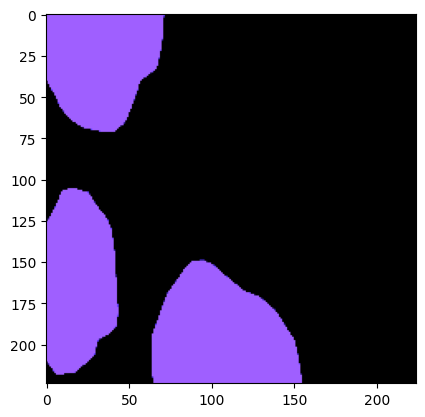

In [30]:
image = cv2.imread(mask_paths[25])
image = tf.image.resize(image, (224, 224))

image /= 133.
plt.imshow(image)

In [31]:
model.save_weights('checkpoin.weights.h5')